In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler

# Variables from config file
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup/')
from util import load_data
from config import FILENAME, C_SINGLE, C_GRID, C_COMMON
# enable autoreload
%load_ext autoreload
%autoreload 2

2022-08-06 20:56:55.610307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
columns = C_SINGLE + ['elevation', 'lat', 'lon']
n_run = 100

df_train, df_test = load_data(columns + C_COMMON, FILENAME)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def define_model(
    input_dim=20,
    n_units=512,
    activation='selu',#selu
    learning_rate=0.00001,
    loss='mse',
    batch_size=64
):
    inputs = Input(shape=(input_dim))
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=1e-3))(inputs)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=1e-3))(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=1e-3))(x)
    x = Dropout(rate=0.5)(x)# serves as regularization
    outputs = Dense(units=1, activation='softplus', kernel_regularizer=L2(l2=1e-3))(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=[RootMeanSquaredError()]
    )
    return model, batch_size


In [32]:
from sklearn.preprocessing import MinMaxScaler

class TransferModel():
    def __init__(self, model_func, columns):
        self.model_func = model_func
        self.columns = columns
        
    def train_and_save_base_model(self, model_path, params):
        """
        Train the base model and saves it
        """
        pass
            
    def split_scale(self, df_train, df_test):
        # convert to numpy
        x_train, x_test = np.array(df_train[self.columns]), np.array(df_test[self.columns])
        y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])
        
        # scale x
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        
        # scale y
        y_train = np.log(y_train + 1.)
        y_test = np.log(y_test + 1.)
        
        return x_train, x_test, y_train, y_test

    def train_base(self, x, y, retrain_full):
        pass
    
    def cross_val_predict_base(self, df, params, n_folds=5):
        """
        Run 5-fold cross validataion on entire dataset to choose hyperparameter for the base model
        """
        list_ytrue = []
        list_ypred = []
        for k in range(n_folds):
            df_train = df[df['inner_fold'] != k]
            df_test = df[df['inner_fold'] == k]
            
            x_train, x_test, y_train, y_test = self.split_scale(df_train, df_test)
            
            model, batch_size = self.model_func(**params)
            model.fit(x_train, y_train)
            
            callbacks = [
                EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
            ]

            history = model.fit(
                x_train, y_train,
                epochs=int(1e3),
                validation_split=0.2,
                callbacks=callbacks,
                verbose=1
            )
            
            y_pred = model.predict(x_test)
            list_ytrue.extend(np.power(np.e, y_test))
            list_ypred.extend(np.power(np.e, y_pred))
        # calculate the loss and return
        return {
            "rmse": mean_squared_error(list_ytrue, list_ypred, squared=False),
            "mae": mean_absolute_error(list_ytrue, list_ypred),
            # 'epochs': len(history.history['loss'])
        }
    
    def cross_val_predict_station(self, df, skn, n_folds=5):
        """
        Run 5-fold cross validation on a single station.
        """
        df_station = df[df['skn'] == skn]
        
        list_ytrue = []
        list_ypred = []
        for k in range(n_folds):
            df_train = df_station[df_station['inner_fold'] != k]
            df_test = df_station[df_station['inner_fold'] == k]
            
            x_train, x_test, y_train, y_test = self.split_scale(df_train, df_test)
                    
    def inverse_transform_y():
        pass
    
    def pre_train(x, y):
        pass
    

In [33]:
t_model = TransferModel(define_model, columns)
params={
           'n_units': 512,
           'learning_rate': 0.001,
           'input_dim': 19,
           'batch_size': 64,
           'loss': 'mse'
       }
t_model.cross_val_predict_base(df_train, params)


<class 'function'>
<function define_model at 0x2ad213e6c940>
<class 'function'>
370/370 [==============================] - 1s 2ms/step - loss: 2.1963 - root_mean_squared_error: 1.0800
Epoch 1/1000
296/296 [==============================] - 1s 3ms/step - loss: 1.4131 - root_mean_squared_error: 0.8065 - val_loss: 1.2713 - val_root_mean_squared_error: 0.7722
Epoch 2/1000
296/296 [==============================] - 1s 3ms/step - loss: 1.2127 - root_mean_squared_error: 0.7858 - val_loss: 1.0737 - val_root_mean_squared_error: 0.7451
Epoch 3/1000
296/296 [==============================] - 1s 3ms/step - loss: 1.0446 - root_mean_squared_error: 0.7702 - val_loss: 0.9237 - val_root_mean_squared_error: 0.7313
Epoch 4/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.9164 - root_mean_squared_error: 0.7613 - val_loss: 0.8494 - val_root_mean_squared_error: 0.7489
Epoch 5/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.8130 - root_mean_squared_error: 0.7504 - v

KeyboardInterrupt: 

In [34]:
import multiprocessing as mp
mp.cpu_count()

20

In [5]:
from sklearn.preprocessing import MinMaxScaler

def evaluate(y_train, y_test):
    a = np.power(np.e, y_train) - 1.
    b = np.power(np.e, y_test) - 1.
    return mean_squared_error(a, b, squared=False)

df_train, df_test = load_data(columns + C_COMMON, FILENAME)

x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

y_train = np.log(y_train + 1.)
y_test = np.log(y_test + 1.)

params={
           'n_units': 512,
           'learning_rate': 0.001,
           'input_dim': 19,
           'batch_size': 64,
           'loss': 'mse'
       }

model, batch_size = define_model(**params)

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
]

history = model.fit(
    x_train, y_train,
    epochs=int(1e3),
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

2022-08-06 20:56:58.601354: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-06 20:56:58.602997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-06 20:56:58.658275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-06 20:56:58.658319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-06 20:56:58.660980: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-06 20:56:58.661054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

Epoch 1/1000


2022-08-06 20:57:00.064698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


370/370 [==============================] - 2s 5ms/step - loss: 2.0628 - root_mean_squared_error: 1.0225 - val_loss: 1.4965 - val_root_mean_squared_error: 0.8218
Epoch 2/1000
370/370 [==============================] - 1s 3ms/step - loss: 1.4569 - root_mean_squared_error: 0.8315 - val_loss: 1.1692 - val_root_mean_squared_error: 0.7589
Epoch 3/1000
370/370 [==============================] - 1s 3ms/step - loss: 1.2020 - root_mean_squared_error: 0.8073 - val_loss: 0.9637 - val_root_mean_squared_error: 0.7423
Epoch 4/1000
370/370 [==============================] - 1s 3ms/step - loss: 0.9632 - root_mean_squared_error: 0.7670 - val_loss: 0.9530 - val_root_mean_squared_error: 0.8227
Epoch 5/1000
370/370 [==============================] - 1s 3ms/step - loss: 0.8660 - root_mean_squared_error: 0.7819 - val_loss: 0.6930 - val_root_mean_squared_error: 0.7105
Epoch 6/1000
370/370 [==============================] - 1s 3ms/step - loss: 0.7469 - root_mean_squared_error: 0.7569 - val_loss: 0.6601 - val_r

In [6]:
evaluate(model.predict(x_test), y_test)

3.6941482977420272

In [133]:
df_train, df_test = load_data(columns + C_COMMON, FILENAME)

x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

y_train = np.log(y_train + 1.)
y_test = np.log(y_test + 1.)

params={
           'n_units': 512,
           'learning_rate': 0.001,
           'input_dim': 19,
           'batch_size': 64,
           'loss': 'mse'
       }

model, batch_size = define_model(**params)

callbacks = [EarlyStopping(monitor='loss', min_delta=0, patience=1000, restore_best_weights=True)]
###################REDUCELRONPLATEAU?
history = model.fit(
    x_train, y_train,
    epochs=len(history.history['loss']),
    validation_split=0,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/93
462/462 [==============================] - 1s 2ms/step - loss: 2.0543 - root_mean_squared_error: 1.0255
Epoch 2/93
462/462 [==============================] - 1s 2ms/step - loss: 1.3202 - root_mean_squared_error: 0.8004
Epoch 3/93
462/462 [==============================] - 1s 2ms/step - loss: 1.0167 - root_mean_squared_error: 0.7632
Epoch 4/93
462/462 [==============================] - 1s 2ms/step - loss: 0.8493 - root_mean_squared_error: 0.7635
Epoch 5/93
462/462 [==============================] - 1s 2ms/step - loss: 0.7209 - root_mean_squared_error: 0.7411
Epoch 6/93
462/462 [==============================] - 1s 2ms/step - loss: 0.6667 - root_mean_squared_error: 0.7357
Epoch 7/93
462/462 [==============================] - 1s 2ms/step - loss: 0.6204 - root_mean_squared_error: 0.7166
Epoch 8/93
462/462 [==============================] - 1s 2ms/step - loss: 0.6101 - root_mean_squared_error: 0.7138
Epoch 9/93
462/462 [==============================] - 1s 2ms/step - loss: 0.5970

In [134]:
evaluate(model.predict(x_test), y_test)

3.5651061945070195

In [135]:
model.save('model_weights/pretrained_model.hdf5')

In [4]:
model = tf.keras.models.load_model('model_weights/pretrained_model.hdf5')

In [9]:
XTRAIN = np.array(df_train[columns])
scaler = MinMaxScaler()
scaler.fit(XTRAIN)

MinMaxScaler()

In [10]:
skn = 54
df_train_station = df_train[df_train['skn'] == skn]
df_test_station = df_test[df_test['skn'] == skn]

x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])

# scaler = MinMaxScaler()
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = np.log(y_train + 1.)
y_test = np.log(y_test + 1.)

In [11]:
y_pred = model.predict(x_test)
mean_squared_error(np.power(np.e, y_test), np.power(np.e, y_pred), squared=False)

5.1927155804311464

In [4]:
# # pre-train the model
# # at this point, dataset includes all station
# x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
# y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# y_train = np.log(y_train + 1.)
# y_test = np.log(y_test + 1.)

# model, batch_size = define_model(**{
#         'n_units': 835,
#         'learning_rate': 0.00012633633813255,
#         'input_dim': 19,
#         'batch_size': 64,
#         'loss': 'mse'
#     })
# callbacks = [
#     EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
# ]
# history = model.fit(
#     x_train, y_train,
#     epochs=int(1e3),
#     validation_split=0.2,
#     callbacks=callbacks,
#     verbose=1
# )

2022-08-05 08:45:50.980033: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-05 08:45:50.981839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-05 08:45:51.040036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-05 08:45:51.040083: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-05 08:45:51.042914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-05 08:45:51.042987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

Epoch 1/1000


2022-08-05 08:45:52.397309: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


370/370 [==============================] - 2s 4ms/step - loss: 306.5169 - root_mean_squared_error: 0.9431 - val_loss: 48.3592 - val_root_mean_squared_error: 0.8377
Epoch 2/1000
370/370 [==============================] - 1s 3ms/step - loss: 23.1935 - root_mean_squared_error: 0.8746 - val_loss: 2.4718 - val_root_mean_squared_error: 0.8621
Epoch 3/1000
370/370 [==============================] - 1s 3ms/step - loss: 2.0213 - root_mean_squared_error: 0.8969 - val_loss: 1.0841 - val_root_mean_squared_error: 0.8620
Epoch 4/1000
370/370 [==============================] - 1s 3ms/step - loss: 1.0680 - root_mean_squared_error: 0.8924 - val_loss: 0.9356 - val_root_mean_squared_error: 0.8618
Epoch 5/1000
370/370 [==============================] - 1s 3ms/step - loss: 0.9778 - root_mean_squared_error: 0.8865 - val_loss: 0.9378 - val_root_mean_squared_error: 0.8632
Epoch 6/1000
370/370 [==============================] - 1s 3ms/step - loss: 0.9918 - root_mean_squared_error: 0.8945 - val_loss: 0.9386 - v

In [5]:
# model.save('model_weights/pretrained_model.hdf5')

In [11]:
# model = tf.keras.models.load_model('model_weights/pretrained_model.hdf5')

In [14]:
# model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 835)               16700     
_________________________________________________________________
dropout (Dropout)            (None, 835)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 835)               698060    
_________________________________________________________________
dropout_1 (Dropout)          (None, 835)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 835)               698060    
_________________________________________________________________
dropout_2 (Dropout)          (None, 835)               0     

In [7]:
# # load the model
# model = tf.keras.models.load_model('model_weights/pretrained_model.hdf5')

# inputs = Input(shape=(19,))
# x = model.layers[1](inputs)
# for i in range(1,7):
#     x = model.layers[i](x)
# # add some more layers

In [83]:
# model = tf.keras.models.load_model('model_weights/pretrained_model.hdf5')

# skn = 54
# df_train_station = df_train[df_train['skn'] == skn]
# df_test_station = df_test[df_test['skn'] == skn]

# x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
# y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# y_train = np.log(y_train + 1.)
# y_test = np.log(y_test + 1.)

# model.predict(x_test)

array([[2.0173483],
       [2.3068035],
       [1.484434 ],
       [1.8738514],
       [1.8402772],
       [1.4511802],
       [1.3824154],
       [1.8256574],
       [1.8480927],
       [1.6335468],
       [1.8386384],
       [1.5369991],
       [1.5009068],
       [2.223268 ],
       [1.911875 ],
       [1.7666675],
       [1.4653305],
       [1.8615429],
       [1.447156 ],
       [1.5217774],
       [1.55392  ],
       [1.7389773],
       [1.5321418],
       [1.9927708],
       [2.1878324],
       [1.9144356],
       [2.4151196],
       [1.9335229],
       [1.9365933],
       [1.4912297],
       [1.5456198],
       [1.7291096],
       [1.3412048],
       [1.8488936],
       [1.3525634],
       [1.6275703],
       [1.7616951],
       [1.8603588],
       [1.779973 ],
       [2.002844 ],
       [1.3857176],
       [1.3450066],
       [1.4333831],
       [1.7059505],
       [1.3043767],
       [1.4824072],
       [1.836043 ],
       [2.0391724],
       [2.4635303],
       [2.1883385],


In [12]:
def load_trained_model():
    trained_model = tf.keras.models.load_model('model_weights/pretrained_model.hdf5')
    inputs = tf.keras.Input(shape=(19,))
    x = trained_model.layers[1](inputs)
    for i in range(2, 6):
        x = trained_model.layers[i](x)
    outputs = trained_model.layers[6](x)
    _model = tf.keras.Model(inputs, outputs)
    
    return _model

def create_model():
    base_model = load_trained_model()
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(19,))

    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dense(units=128, kernel_regularizer=L2(l2=0.001), activation='selu')(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=128, kernel_regularizer=L2(l2=0.001), activation='selu')(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=128, kernel_regularizer=L2(l2=0.001), activation='selu')(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    outputs = tf.keras.layers.Dense(units=1, kernel_regularizer=L2(l2=0.001), activation='softplus')(x)
    
    complete_model = tf.keras.Model(inputs, outputs)
    complete_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return complete_model

In [18]:
model = create_model()

skn = 54
df_train_station = df_train[df_train['skn'] == skn]
df_test_station = df_test[df_test['skn'] == skn]

x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])

scaler = MinMaxScaler()
#XTRAIN = np.array(df_train[columns])
#scaler = MinMaxScaler()
#scaler.fit(XTRAIN)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = np.log(y_train + 1.)
y_test = np.log(y_test + 1.)

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
]
history = model.fit(
    x_train, y_train,
    epochs=int(1e3),
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/1000
16/16 [==============================] - 1s 18ms/step - loss: 3.8949 - root_mean_squared_error: 1.8037 - val_loss: 1.5202 - val_root_mean_squared_error: 0.9667
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 1.5353 - root_mean_squared_error: 0.9703 - val_loss: 0.8712 - val_root_mean_squared_error: 0.5358
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 1.1468 - root_mean_squared_error: 0.7504 - val_loss: 0.8496 - val_root_mean_squared_error: 0.5175
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 1.0809 - root_mean_squared_error: 0.7068 - val_loss: 1.0246 - val_root_mean_squared_error: 0.6674
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 1.0418 - root_mean_squared_error: 0.6805 - val_loss: 0.8710 - val_root_mean_squared_error: 0.5427
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 1.0862 - root_mean_squared_error: 0.7142 - val_loss: 1.3203 - val

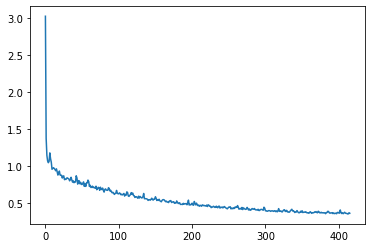

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [20]:
y_pred = model.predict(x_test)
y_pred = np.power(np.e, y_pred) + 1.
y_test_ = np.power(np.e, y_test) + 1.

mean_squared_error(y_test_, y_pred, squared=False)

4.942516484027011

In [237]:
# model.trainable = True
model.save('model_weights/ready_for_fine_tune.hdf5')

In [252]:
model = tf.keras.models.load_model('model_weights/ready_for_fine_tune.hdf5')
model.trainable = True

# first train with strict patience with validation set
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2)
]
            
history = model.fit(
    x_train, y_train,
    epochs=int(1e3),
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/1000
16/16 [==============================] - 1s 16ms/step - loss: 0.3717 - root_mean_squared_error: 0.4614 - val_loss: 0.3675 - val_root_mean_squared_error: 0.4595
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3744 - root_mean_squared_error: 0.4673 - val_loss: 0.3626 - val_root_mean_squared_error: 0.4564
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3669 - root_mean_squared_error: 0.4615 - val_loss: 0.3967 - val_root_mean_squared_error: 0.4945
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3572 - root_mean_squared_error: 0.4531 - val_loss: 0.3774 - val_root_mean_squared_error: 0.4765
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3657 - root_mean_squared_error: 0.4638 - val_loss: 0.3592 - val_root_mean_squared_error: 0.4587
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3580 - root_mean_squared_error: 0.4576 - val_loss: 0.3507 - val

In [253]:
y_pred = model.predict(x_test)
y_pred = np.power(np.e, y_pred) + 1.
mean_squared_error(y_test_, y_pred, squared=False)

4.899945757642023

In [255]:
# now redo with the whole training data

model = tf.keras.models.load_model('model_weights/ready_for_fine_tune.hdf5')
model.trainable = True

# first train with strict patience with validation set
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

callbacks = [
    EarlyStopping(monitor='loss', min_delta=0, patience=1000, restore_best_weights=True),
    # ReduceLROnPlateau(monitor='loss', factor=0.9, patience=2)
]
            
model.fit(
    x_train, y_train,
    epochs=len(history.history['loss']),
    validation_split=0,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/77
20/20 [==============================] - 1s 3ms/step - loss: 0.3585 - root_mean_squared_error: 0.4480
Epoch 2/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3627 - root_mean_squared_error: 0.4557
Epoch 3/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3533 - root_mean_squared_error: 0.4482
Epoch 4/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3462 - root_mean_squared_error: 0.4428
Epoch 5/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3656 - root_mean_squared_error: 0.4664
Epoch 6/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3221 - root_mean_squared_error: 0.4199
Epoch 7/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3285 - root_mean_squared_error: 0.4293
Epoch 8/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3233 - root_mean_squared_error: 0.4257
Epoch 9/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3435 - root_mean_squar

In [256]:
y_pred = model.predict(x_test)
y_pred = np.power(np.e, y_pred) + 1.
mean_squared_error(y_test_, y_pred, squared=False)

4.841681178097757